# Lecture 5. Topic Models

In this notebook we will go through different dimentionality reduction methods and create topics for the dataset of Supreme Court cases.

In [5]:
# set random seed
import numpy as np
np.random.seed(4)
import seaborn as sns
sns.set_theme()

In [6]:
# Setup
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
df = pd.read_pickle('sc_cases_cleaned.pkl',compression='gzip')

In [7]:
from gensim.utils import simple_preprocess
text0 = ' '.join(simple_preprocess(df['opinion_text'][0]))
text1 = ' '.join(simple_preprocess(df['opinion_text'][1]))

text1[:1000]

'justice stevens delivered the opinion of the court in most of the united states not including california the minimum price paid to dairy farmers producing raw milk is regulated pursuant to federal marketing orders those orders guarantee uniform price for the producers but through pooling mechanisms require the processors of different classes of dairy products to pay different prices thus for example processors of fluid milk pay premium price part of which goes into an equalization pool that provides partial subsidy for cheese manufacturers who pay net price that is lower than the farmers receive seewest lynn creamery inc healy ed ct the california legislature has adopted similar program to regulate the minimum prices paid by california processors to california producers in the cases before us today out of state producers are challenging the of amendment to that program they present us with two questions whether of the federal agriculture improvement and reform act of stat usc uscs exe

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=0.01, # at min 1% of docs
                        max_df=.9,  
                        max_features=500,
                        stop_words='english',
                        ngram_range=(1,3))
X = vectorizer.fit_transform(df['preprocessed'])
words = vectorizer.get_feature_names_out()

In [5]:
X = X.todense()
X = X / X.sum(axis=1)
features = []
for i, word in enumerate(words):
    column = X[:,i]
    df['x_'+word] = np.ravel(column)
    features.append('x_'+word)
df.head()

,case_name,opinion_type,date_standard,authorship,x_republican,maj_judges,dissent_judges,topic_id,cite_count,opinion_text,...,x_view,x_violat,x_vote,x_warrant,x_water,x_way,x_wit,x_word,x_work,x_year
0,ERICK CORNELL CLAY v. UNITED STATES,majority,2003-03-04,GINSBURG,0.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],1.0,2926.0,JUSTICE GINSBURG delivered the opinion of the ...,...,0.001486,0.002972,0.0,0.001486,0.000000,0.002972,0.000000,0.011887,0.000000,0.004458
1,"HILLSIDE DAIRY INC., A&A DAIRY, L&S DAIRY, AND...",majority,2003-06-09,STEVENS,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...","['THOMAS, CLARENCE']",8.0,117.0,Justice Stevens delivered the opinion of the C...,...,0.000000,0.004107,0.0,0.000000,0.000000,0.000000,0.000000,0.002053,0.000000,0.000000
2,"CHARLES RUSSELL RHINES v. DOUGLAS WEBER, WARDEN",majority,2005-03-30,O'CONNOR,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],1.0,23364.0,Justice O'Connor delivered the opinion of the ...,...,0.000000,0.001464,0.0,0.000000,0.000000,0.001464,0.000000,0.000000,0.000000,0.001464
4,STATE OF ALASKA v. UNITED STATES OF AMERICA,majority,2005-06-06,KENNEDY,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...","['REHNQUIST, WILLIAM', 'SCALIA, ANTONIN', 'THO...",10.0,84.0,Justice Kennedy delivered the opinion of the C...,...,0.008020,0.000000,0.0,0.000000,0.063158,0.002506,0.000000,0.000501,0.000501,0.002005
5,"REGINALD A. WILKINSON, DIRECTOR, OHIO DEPARTME...",majority,2005-06-13,KENNEDY,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],4.0,4230.0,Justice Kennedy delivered the opinion of the C...,...,0.000781,0.004684,0.0,0.000000,0.000000,0.000000,0.006245,0.000781,0.000781,0.003123


## Principal Component Analysis

How it works (more info [here](https://towardsdatascience.com/principal-component-analysis-for-dimensionality-reduction-115a3d157bad)):

1. Construct the covariance matrix of the standardized features
2. Get the eigenvectors and eigenvalues
3. Select k eigenvectors which correspond to the k largest eigenvalues, where k is the dimensionality of the new feature subspace (the number of principal components)
4. Construct the projection matrix from these k eigenvectors and transform the features using this matrix

In [6]:
#%% Principal Components
y = (df['log_cite_count']>df.log_cite_count.mean()).astype('int')
X = df[features]

from sklearn.decomposition import PCA
pca = PCA(n_components=5,svd_solver='randomized')
Xpca = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.05998923, 0.04364894, 0.03286089, 0.0285669 , 0.0223789 ])

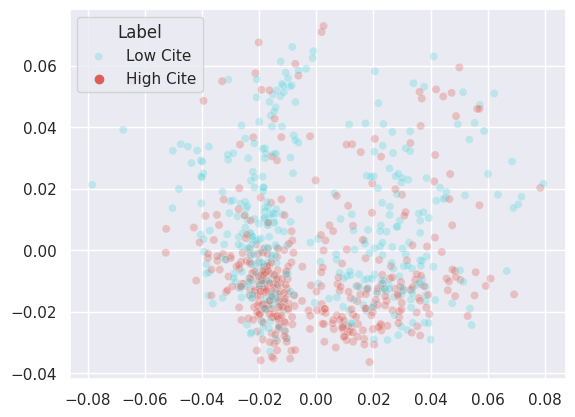

In [7]:
plot = sns.scatterplot(
    x=Xpca[:,0], y=Xpca[:,1],
    hue=y,
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.3
)

plt.legend(title='Label', loc='upper left', labels=["Low Cite", "High Cite"])
plt.show(plot)

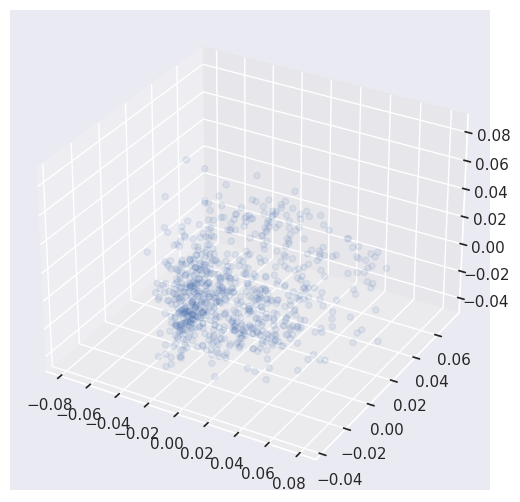

In [8]:
#%% PCA 3D Viz
from mpl_toolkits.mplot3d import Axes3D
Axes3D(plt.figure()).scatter(Xpca[:,0],Xpca[:,1], Xpca[:,2], alpha=.1)
plt.show()

In [9]:
#%% make components to explain 95% of variance
pca = PCA(n_components=.95)
X95 = pca.fit_transform(X)
pca.n_components_

234

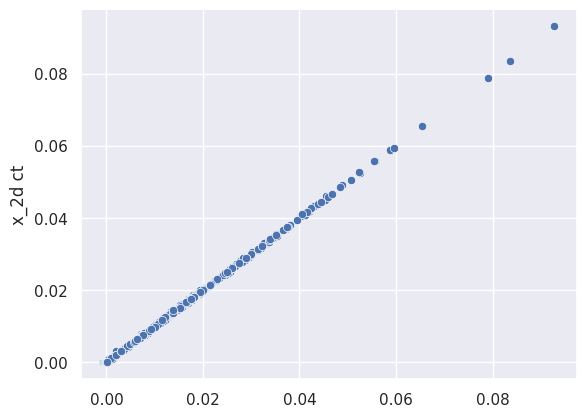

In [10]:
#%% PCA Inverse Transform
Xrestore = pca.inverse_transform(X95)
plot = sns.scatterplot(x=Xrestore[:,0],y=X.iloc[:, 0])

In [11]:
#%% Incremental PCA
# X_mm = np.memmap(X,shape=(32567, 525))

from sklearn.decomposition import IncrementalPCA
inc_pca = IncrementalPCA(n_components=100, batch_size=1000)
inc_pca.fit(X)

IncrementalPCA(batch_size=1000, n_components=100)

In [12]:
#%% PC Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
Y = df['log_cite_count']
lin_reg = LinearRegression()
scores = cross_val_score(lin_reg,
                         X95[:,:10],
                         Y) 
scores.mean()

0.17039759572177257

#### [MDS](https://towardsdatascience.com/mds-multidimensional-scaling-smart-way-to-reduce-dimensionality-in-python-7c126984e60b), [Isomap](https://towardsdatascience.com/isomap-embedding-an-awesome-approach-to-non-linear-dimensionality-reduction-fc7efbca47a0), [T-SNE](https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1)


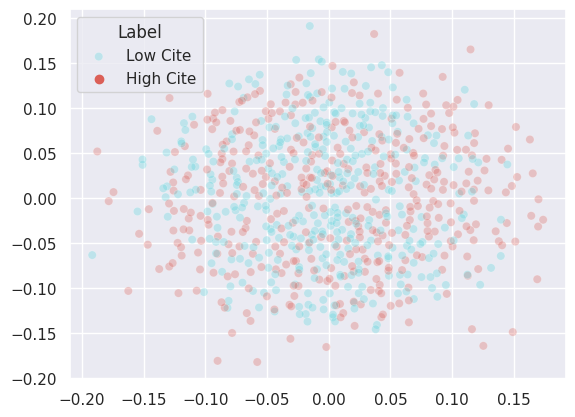

In [13]:
#%% MDS, Isomap, and T-SNE
from sklearn.manifold import MDS, Isomap, TSNE
mds = MDS(n_components=2)
Xmds = mds.fit_transform(X)
plot = sns.scatterplot(
    x=Xmds[:,0], y=Xmds[:,1],
    hue=y,
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.3
)

plt.legend(title='Label', loc='upper left', labels=["Low Cite", "High Cite"])
plt.show(plot)

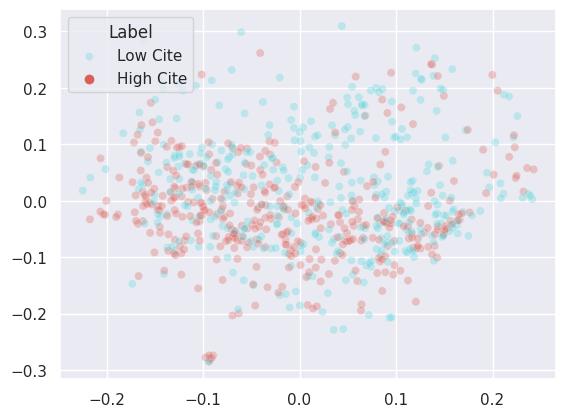

In [14]:
#%% Isomap
iso = Isomap(n_components=2)
Xiso = iso.fit_transform(X)
plot = sns.scatterplot(
    x=Xiso[:,0], y=Xiso[:,1],
    hue=y,
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.3
)

plt.legend(title='Label', loc='upper left', labels=["Low Cite", "High Cite"])
plt.show(plot)

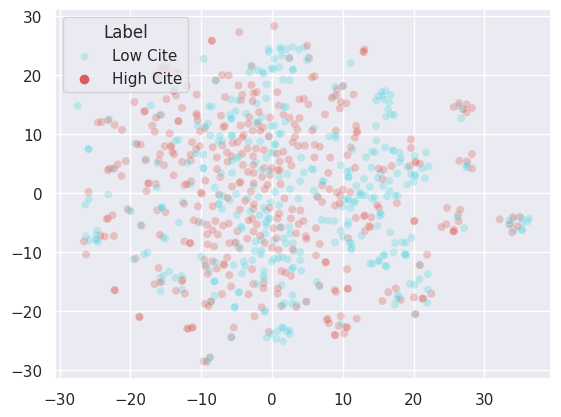

In [15]:
#%% t-SNE
tsne = TSNE(n_components=2, n_iter=500, perplexity=25)
Xtsne = tsne.fit_transform(X)
plot = sns.scatterplot(
    x=Xtsne[:,0], y=Xtsne[:,1],
    hue=y,
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.3
)

plt.legend(title='Label', loc='upper left', labels=["Low Cite", "High Cite"])
plt.show(plot)

# Latent Dirichlet Allocation

For further reference see the material from topic [modeling with gensim](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/).

In [8]:
# clean document
from gensim.utils import simple_preprocess
import spacy
from spacy.tokenizer import Tokenizer
from tqdm import tqdm as tq
nlp = spacy.load('en_core_web_sm')
# this is faster and we don't need the whole grammatical parse analysis

def tokenize(x, nlp):
    # lemmatize and lowercase without stopwords, punctuation and numbers
    return [w.lemma_.lower() for w in nlp(x) if not w.is_stop and not w.is_punct and not w.is_digit and len(w) > 2]

# split into paragraphs
doc_clean = []
for doc in tq(df['opinion_text'][:100]):
    # split by paragraph
    for paragraph in doc.split("\n\n"):
        doc_clean.append(tokenize(paragraph, nlp))

# randomize document order
from random import shuffle
shuffle(doc_clean)

# creating the term dictionary
from gensim import corpora
dictionary = corpora.Dictionary(doc_clean)
# filter extremes, drop all words appearing in less than 10 paragraphs and all words appearing in at least every third paragraph
dictionary.filter_extremes(no_below=10, no_above=0.33, keep_n=1000)
print (len(dictionary))

100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


1000


In [17]:
# creating the document-term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# train LDA with 10 topics and print
from gensim.models.ldamodel import LdaModel
lda = LdaModel(doc_term_matrix, num_topics=10, 
               id2word = dictionary, passes=3)
lda.show_topics(formatted=False)

[(0,
  [('petitioner', 0.027968194),
   ('opinion', 0.018612944),
   ('justice', 0.0165004),
   ('u.s.', 0.015271234),
   ('case', 0.01425865),
   ('search', 0.013879145),
   ('warrant', 0.012241585),
   ('fact', 0.012051973),
   ('officer', 0.011874528),
   ('respondent', 0.010199463)]),
 (1,
  [('u.s.', 0.046479225),
   ('state', 0.03615552),
   ('interest', 0.017361103),
   ('claim', 0.0171866),
   ('law', 0.016958093),
   ('rule', 0.016899694),
   ('policy', 0.0153800035),
   ('government', 0.014992674),
   ('federal', 0.0128052095),
   ('review', 0.009891131)]),
 (2,
  [('party', 0.036099043),
   ('arbitration', 0.028913585),
   ('agreement', 0.023853831),
   ('district', 0.021140678),
   ('dispute', 0.016526649),
   ('contract', 0.014168469),
   ('u.s.', 0.013482588),
   ('plan', 0.012901568),
   ('case', 0.011076389),
   ('class', 0.01102423)]),
 (3,
  [('act', 0.02319559),
   ('commission', 0.01448414),
   ('u.s.', 0.014397542),
   ('state', 0.013152448),
   ('u.s.c.', 0.011570

In [18]:
# to get the topic proportions for a document, use
# the corresponding row from the document-term matrix.
lda[doc_term_matrix[1]]

[(2, 0.41120288),
 (3, 0.19284904),
 (5, 0.08501245),
 (7, 0.16126327),
 (9, 0.13776165)]

In [19]:
# or, for all documents
[lda[d] for d in doc_term_matrix]

[[(4, 0.35865766), (9, 0.62565076)],
 [(2, 0.41121528),
  (3, 0.19278246),
  (5, 0.085043125),
  (7, 0.16131566),
  (9, 0.1377327)],
 [(1, 0.21326417), (2, 0.3180822), (7, 0.18294482), (9, 0.26856136)],
 [(0, 0.20791596), (1, 0.5061771), (7, 0.27131855)],
 [(4, 0.5087965), (5, 0.40780324), (7, 0.06993522)],
 [(0, 0.81997675),
  (1, 0.020001246),
  (2, 0.020001788),
  (3, 0.020001248),
  (4, 0.020002207),
  (5, 0.020005073),
  (6, 0.020002028),
  (7, 0.020002604),
  (8, 0.020000992),
  (9, 0.020006059)],
 [(1, 0.45084623), (2, 0.25429404), (3, 0.1433015), (7, 0.14138338)],
 [(2, 0.079331934), (6, 0.89208615)],
 [(0, 0.19117185), (7, 0.47292784), (8, 0.32189447)],
 [(0, 0.1),
  (1, 0.1),
  (2, 0.1),
  (3, 0.1),
  (4, 0.1),
  (5, 0.1),
  (6, 0.1),
  (7, 0.1),
  (8, 0.1),
  (9, 0.1)],
 [(1, 0.2962823), (2, 0.07623176), (3, 0.39697596), (5, 0.22168283)],
 [(3, 0.24137439), (7, 0.7471937)],
 [(1, 0.13748747), (5, 0.6567513), (6, 0.20191352)],
 [(4, 0.059968825), (6, 0.08735013), (7, 0.500721

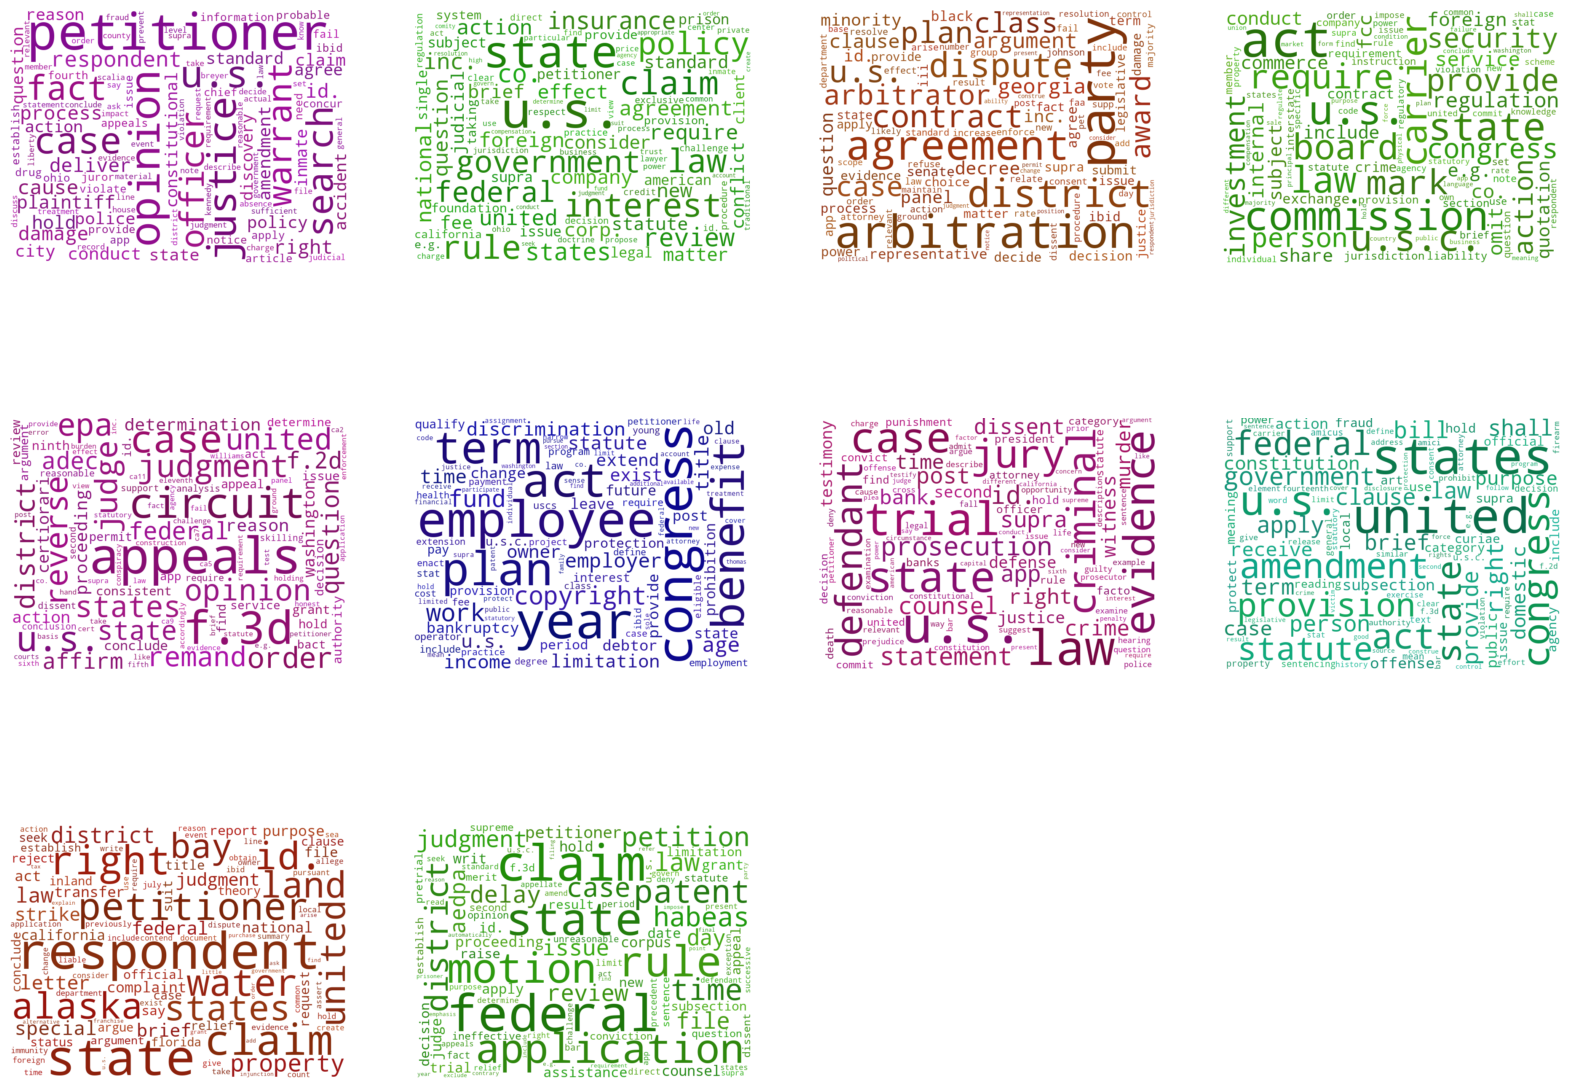

In [20]:
###
# LDA Word Clouds
###

from numpy.random import randint
from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = [20, 15]
# make word clouds for the topics
for i,weights in lda.show_topics(num_topics=-1,
                                 num_words=100,
                                 formatted=False):
    
    #logweights = [w[0], np.log(w[1]) for w in weights]
    maincol = randint(0,360)
    def colorfunc(word=None, font_size=None, 
                  position=None, orientation=None, 
                  font_path=None, random_state=None):   
        color = randint(maincol-10, maincol+10)
        if color < 0:
            color = 360 + color
        return "hsl(%d, %d%%, %d%%)" % (color,randint(65, 75)+font_size / 7, randint(35, 45)-font_size / 10)   

    
    wordcloud = WordCloud(background_color="white", 
                          ranks_only=False, 
                          max_font_size=120,
                          color_func=colorfunc,
                          height=600,width=800).generate_from_frequencies(dict(weights))

    plt.subplot(3, 4, i+1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    

In [21]:
# pyLDAvis, for more details, refer to https://github.com/bmabey/pyLDAvis
#!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
gensimvis.prepare(lda, doc_term_matrix, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.089258  0.030850       1        1  14.570685
6     -0.067713  0.016735       2        1  11.863598
9     -0.080156 -0.095348       3        1  10.892016
3      0.096411  0.072900       4        1   9.920643
1      0.013796  0.023101       5        1   9.808381
4     -0.136214 -0.061998       6        1   9.202069
5      0.192894 -0.082322       7        1   8.940335
8     -0.018962  0.106365       8        1   8.700286
0     -0.080986  0.099707       9        1   8.357864
2     -0.008327 -0.109992      10        1   7.744122, topic_info=            Term        Freq       Total Category  logprob  loglift
4        appeals  795.000000  795.000000  Default  30.0000  30.0000
60         party  655.000000  655.000000  Default  29.0000  29.0000
43   arbitration  379.000000  379.000000  Default  28.0000  28.0000
13       circuit  442.000000  442.000000  Default  27.0000  27.0000
276         f.3d  721.000000  721.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
113      process   68.613825  365.275048  Topic10  -5.2381   0.8861
222          id.   85.192034  984.213304  Topic10  -5.0217   0.1113
463     decision   70.738934  561.333292  Topic10  -5.2076   0.4869
325         ibid   67.312057  416.655701  Topic10  -5.2573   0.7353
154         term   67.648051  570.493038  Topic10  -5.2523   0.4261

[552 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
916       1  0.016290  ability
916       2  0.065162  ability
916       4  0.032581  ability
916       7  0.065162  ability
916       8  0.244357  ability
...     ...       ...      ...
860       9  0.018813     york
860      10  0.150503     york
769       1  0.038624    young
769       5  0.167370    young
769       7  0.772479    young

[2761 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 7, 10, 4, 2, 5, 6, 9, 1, 3])

Using Mallet to calculate coherence scores for different number of topics to automatically determine the best number of topics. Alternatively, you can use LdaMulticore.

In [23]:
# # you need gensim version <= 3.8.3 for this to work
# import gensim
# from gensim.corpora import Dictionary
# from gensim.models.wrappers import LdaMallet
# from gensim.models.coherencemodel import CoherenceModel

# mallet_path = '~/mallet-2.0.8/bin/mallet'
# scores = []
# for num_topics in range(2, 20, 2):
#     print (num_topics)
#     lda = LdaMallet(mallet_path, doc_term_matrix, num_topics=num_topics, id2word=dictionary)
#     coherence = CoherenceModel(model=lda, texts=doc_clean, corpus=doc_term_matrix, dictionary=dictionary, coherence='c_v')
#     scores.append((num_topics, coherence.get_coherence()))

# topic_scores = pd.DataFrame(scores, columns=["Number of Topics", "Coherence Scores"])

# topic_scores.plot(x="Number of Topics", y="Coherence Scores", title="Coherence Scores by Number of Topics")

## Singular Value Decomposition (SVD)

For further reference for this and the following section see [here](https://github.com/fastai/course-nlp/blob/219d0c217bd83339e21471d31cd787e86d6ec0a0/2-svd-nmf-topic-modeling.ipynb).

In [25]:
from scipy import linalg

# X = pd.read_pickle('X.pkl').todense()
# vec = pd.read_pickle('vec-3grams-1.pkl')
vocab = np.array(vectorizer.get_feature_names_out())
vocab[400:500]


array(['remedi', 'remov', 'render', 'report', 'repres', 'request',
       'resolv', 'respect', 'respond', 'respons', 'restrict', 'result',
       'return', 'rev', 'revers', 'review', 'right', 'risk', 'said',
       'sale', 'satisfi', 'say', 'scheme', 'school', 'scope', 'search',
       'second', 'secretari', 'section', 'secur', 'seek', 'sentenc',
       'separ', 'serv', 'servic', 'set', 'sever', 'shall', 'signific',
       'similar', 'simpli', 'sinc', 'sought', 'special', 'specif',
       'speech', 'stand', 'standard', 'stat', 'state court', 'state law',
       'statement', 'statut', 'statutori', 'student', 'subject',
       'subsect', 'substanti', 'suffici', 'suggest', 'suit', 'supp',
       'support', 'supra', 'supra ct', 'supra ct ed', 'supra ed',
       'supra ed 2d', 'suprem', 'suprem court', 'tax', 'term', 'test',
       'testimoni', 'text', 'therefor', 'think', 'time', 'titl', 'treat',
       'trial', 'trial court', 'tribe', 'turn', 'understand', 'unless',
       'usc', 'use', '

In [26]:
U, s, Vh = linalg.svd(X, full_matrices=False)
print(U.shape, s.shape, Vh.shape)

(768, 500) (500,) (500, 500)


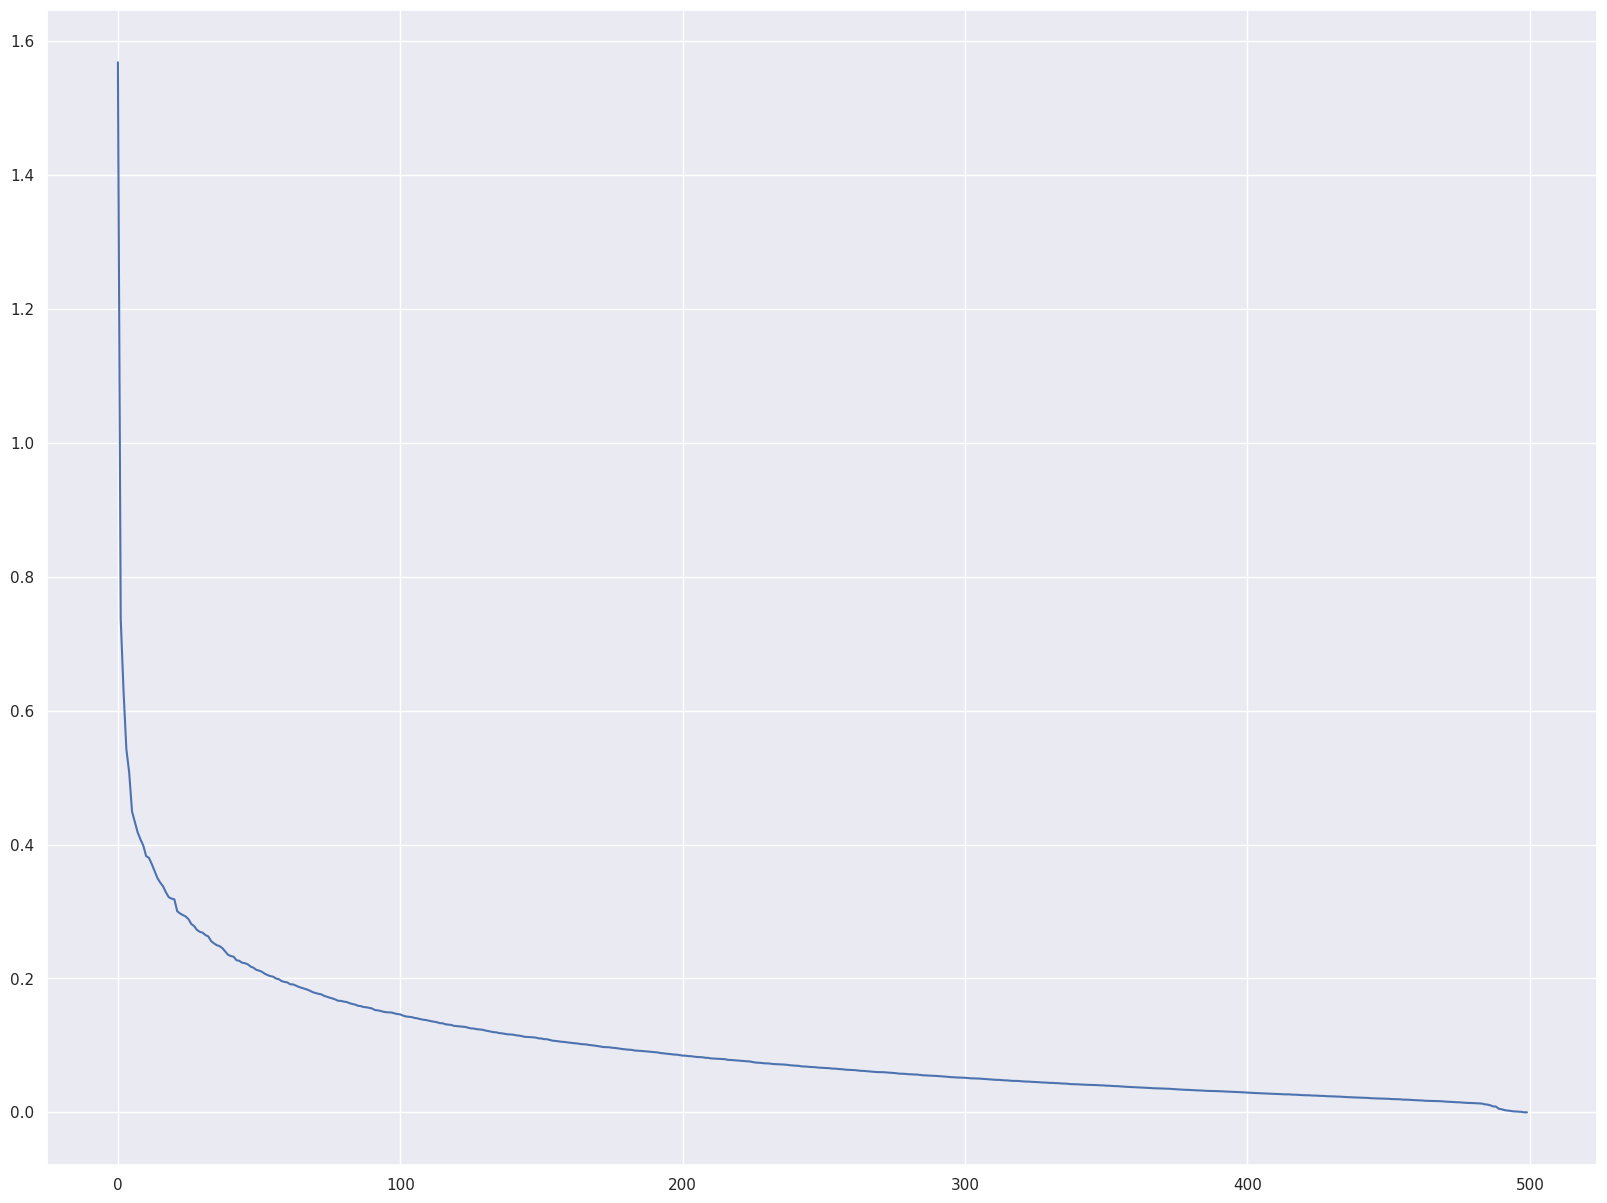

In [27]:
plt.plot(s)

In [28]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

show_topics(Vh[:10])

['candid bear organ care child congression understand contribut',
 'ct ed ct ed 2d id ct id ct ed supra ct supra ct ed trial juri',
 'sentenc defend trial juri evid counsel convict judg',
 'claim district jurisdict district court petit arbitr file parti',
 'offic ed 2d ct 2d ct search right amend ct ed polic',
 'claim tax petition petit file habea offic period',
 'tax incom claim arbitr properti trial counsel right',
 'offic arbitr search petition sentenc offens arrest crime',
 'tax district jurisdict parti govern school district court constitut',
 'right action defend claim counsel jurisdict congress statut']

## BERTopic

You can find (well written) additional information [here](https://maartengr.github.io/BERTopic/index.html)

In [3]:
#!pip install bertopic

from bertopic import BERTopic
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from sentence_transformers import SentenceTransformer, util



def bertopic_cluster(sents, no_topics, emb_model, n_neighb, cluster_model, cluster_par, random_state, finetune):
    embedding_model = SentenceTransformer(emb_model)
    umap_model = UMAP(n_neighbors=n_neighb, n_components=5, 
                      min_dist=0.0, metric='cosine', random_state=random_state)

    if cluster_model == 'kmeans':
        cluster_alg = KMeans(n_clusters = cluster_par, 
                             random_state=random_state)
    elif cluster_model == 'aggl':
        cluster_alg = AgglomerativeClustering(n_clusters=None, 
                                              distance_threshold=cluster_par)
        
    vectorizer_model = CountVectorizer(stop_words="english")
    ctfidf_model = ClassTfidfTransformer()
    if finetune == True:
        representation_model = KeyBERTInspired()
    else:
        representation_model = None

    topic_model = BERTopic(
        nr_topics=no_topics,
        embedding_model=embedding_model,          # Step 1 - Extract embeddings
        umap_model=umap_model,                    # Step 2 - Reduce dimensionality
        hdbscan_model=cluster_alg,              # Step 3 - Cluster reduced embeddings
        vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
        ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
        representation_model=representation_model # Step 6 - (Optional) Fine-tune topic represenations
        )
    topics, probs = topic_model.fit_transform(sents)
    
    return topic_model

In [15]:
docs = df['preprocessed'].tolist()
topic_model = bertopic_cluster(docs, no_topics=10, emb_model='all-MiniLM-L6-v2', n_neighb=15, cluster_model='aggl', cluster_par=1, random_state=42, finetune=True)
df_topics = topic_model.get_document_info(docs)

In [16]:
df_topics

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Representative_document
0,justic ginsburg deliv opinion court motion fed...,0,0_court_convict_appeal_jurisdict,"[court, convict, appeal, jurisdict, trial, dis...",[justic steven deliv opinion court new constit...,court - convict - appeal - jurisdict - trial -...,False
1,justic steven deliv opinion court unit state i...,0,0_court_convict_appeal_jurisdict,"[court, convict, appeal, jurisdict, trial, dis...",[justic steven deliv opinion court new constit...,court - convict - appeal - jurisdict - trial -...,False
2,justic oconnor deliv opinion court confront pr...,0,0_court_convict_appeal_jurisdict,"[court, convict, appeal, jurisdict, trial, dis...",[justic steven deliv opinion court new constit...,court - convict - appeal - jurisdict - trial -...,False
3,justic kennedi deliv opinion court state alask...,1,1_court_tribe_state_tribal,"[court, tribe, state, tribal, jurisdict, permi...",[justic kennedi deliv opinion court maritim oi...,court - tribe - state - tribal - jurisdict - p...,False
4,justic kennedi deliv opinion court case involv...,0,0_court_convict_appeal_jurisdict,"[court, convict, appeal, jurisdict, trial, dis...",[justic steven deliv opinion court new constit...,court - convict - appeal - jurisdict - trial -...,False
...,...,...,...,...,...,...,...
763,justic breyer deliv opinion court appeal revie...,0,0_court_convict_appeal_jurisdict,"[court, convict, appeal, jurisdict, trial, dis...",[justic steven deliv opinion court new constit...,court - convict - appeal - jurisdict - trial -...,False
764,justic souter deliv opinion court question whe...,0,0_court_convict_appeal_jurisdict,"[court, convict, appeal, jurisdict, trial, dis...",[justic steven deliv opinion court new constit...,court - convict - appeal - jurisdict - trial -...,False
765,justic scalia deliv opinion court case present...,0,0_court_convict_appeal_jurisdict,"[court, convict, appeal, jurisdict, trial, dis...",[justic steven deliv opinion court new constit...,court - convict - appeal - jurisdict - trial -...,False
766,justic thoma deliv opinion court control subst...,0,0_court_convict_appeal_jurisdict,"[court, convict, appeal, jurisdict, trial, dis...",[justic steven deliv opinion court new constit...,court - convict - appeal - jurisdict - trial -...,False


## Author Topic Model

In [30]:
from gensim.models import AuthorTopicModel
from gensim.test.utils import temporary_file

df = df.reset_index()
df['id'] = df.index
author2doc = df[:100][['authorship','id']]
author2doc = author2doc.groupby('authorship').apply(lambda x: list(x['id'])).to_dict()
author2doc

{'ALITO': [14, 29, 30, 33, 39, 43],
 'BREYER': [6, 10, 15, 19, 26, 36, 54, 73, 74, 80, 81, 95],
 'GINSBURG': [0, 7, 9, 11, 18, 25, 27, 52, 68, 84, 86, 90, 96, 97],
 'KENNEDY': [3, 4, 16, 21, 34, 40, 42, 48, 62, 64, 65, 76, 85, 87],
 "O'CONNOR": [2, 49, 59, 66, 75, 83, 88],
 'REHNQUIST': [55, 56, 70, 79, 94],
 'ROBERTS': [12, 35, 44],
 'SCALIA': [20, 23, 28, 37, 41, 45, 51, 61, 63, 82, 98],
 'SOUTER': [5, 47, 53, 67, 72, 78, 91, 92],
 'STEVENS': [1, 17, 31, 32, 38, 46, 57, 60, 71, 93],
 'THOMAS': [8, 13, 22, 24, 50, 58, 69, 77, 89, 99]}

In [31]:
model = AuthorTopicModel(
        doc_term_matrix, author2doc=author2doc, id2word=dictionary, num_topics=10)

# For each author list topic distribution
author_vecs = [model.get_author_topics(author) for author in model.id2author.values()]
author_vecs[:2]

[[(4, 0.9836319274419519)], [(2, 0.9982586301336042)]]